# Método de imágenes panorámicas

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [6]:
#Importamos las imagenes 
img0 = cv2.imread("img/udesa_0.jpg")
img1 = cv2.imread("img/udesa_1.jpg")
img2 = cv2.imread("img/udesa_2.jpg")

### 3.1. Detección y descripción de características visuales (features)
En la mayoría de las tareas de visión por computadora, el primer paso para unir un
panorama es detectar y extraer características visuales distintivas.
Pueden seleccionar el tipo de características visuales que prefieran para detectar
y extraer de las imágenes. Pueden utilizar las funciones de OpenCV para esto, tal
como fue visto en las clases tutoriales.

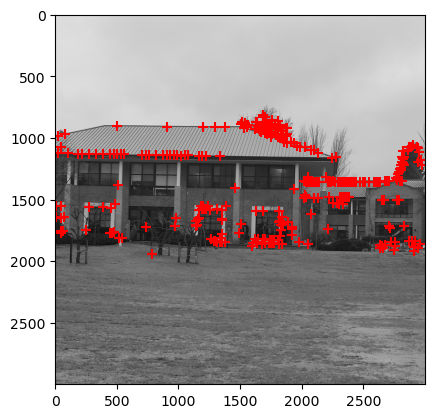

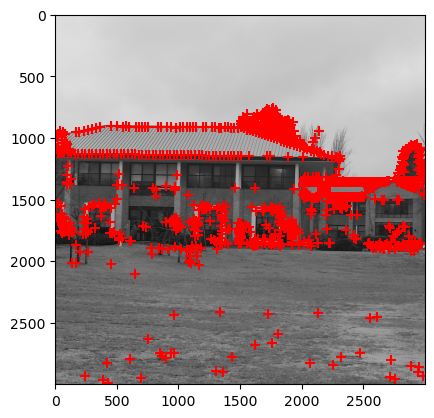

In [ ]:
#Metodo de Harris y Shi-Tomasi

def find_corners(img, method='harris'):

  useHarrisDetector = method=='harris'

  img = np.float32(img)
  corners = cv2.goodFeaturesToTrack(
      img,
      maxCorners=1000,
      qualityLevel=0.05,
      minDistance=11,
      useHarrisDetector=useHarrisDetector
  )

  corners = corners.reshape(-1, 2)
  return corners


def plot_corners(img, **kwargs):

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  corners = find_corners(gray, **kwargs)

  plt.imshow(gray, cmap='gray')
  plt.scatter(corners[:, 0], corners[:, 1], s=50, marker='+', color='red')
  plt.show()


plot_corners(img0, method='harris')
plot_corners(img0, method='shi-tomasi')

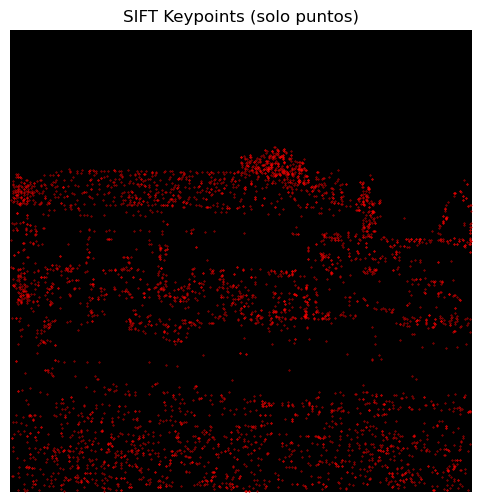

In [35]:
#SIFT

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img0, None)


keypoints_red = []
for kp in keypoints:
    x, y = kp.pt
    if int(x) % 2 == 0 or int(y) % 3 == 0 or int(x) % 5 == 0 or int(y) % 7 == 0 or int(x) % 11 == 0 or int(y) % 13 == 0:
        pass
    else:
        keypoints_red.append(kp)

# Extraer coordenadas de los keypoints
pts = np.array([kp.pt for kp in keypoints_red])

# Mostrar solo los puntos sobre fondo blanco
plt.figure(figsize=(8, 6))
plt.imshow(np.ones(img0.shape[:2]), cmap='gray')  # fondo blanco
plt.scatter(pts[:, 0], pts[:, 1], s=0.1, c='red')
plt.title("SIFT Keypoints (solo puntos)")
plt.axis('off')
plt.show()


### 3.2. Supresión de No Máxima Adaptativa (Adaptive Non-Maximal Suppression, ANMS)
Las características visuales podrían estar condensadas en una porción pequeña
de la imagen. Para poder encontrar transformaciones de calidad nos interesa que
las características visuales estén “bien” distribuidas en la imagen.
Este paso tendrá entonces dos objetivos:
1. Distribuir mejor las coordenadas de los puntos clave.
2. Acotar la cantidad máxima de características visuales que se utilizarán de
la imágen quedándonos con las N mejores que maximicen, además, la
distancia entre ellas.

Keypoints antes de ANMS: 4304
Keypoints despues de ANMS: 100


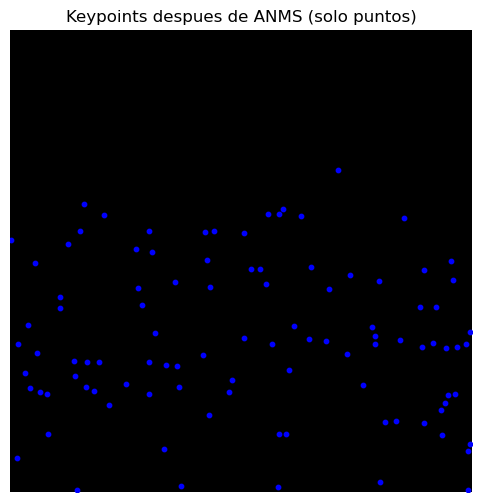

In [36]:
#Adaptative Non Maximal Suppression (ANMS)

def anms(corners, num_corners=100):
    if len(corners) <= num_corners:
        return corners

    # Inicializar radios con un valor grande
    radii = np.full(len(corners), np.inf)

    for i, (x_i, y_i) in enumerate(corners):
        print(f"Procesando punto {i+1}/{len(corners)}", end='\r')
        for j, (x_j, y_j) in enumerate(corners):
            if i != j:
                dist = np.sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2)
                if dist < radii[i]:
                    radii[i] = dist

    # Obtener los índices de los puntos con los mayores radios
    selected_indices = np.argsort(radii)[-num_corners:]

    return corners[selected_indices]

#Imprimo los keypoints SIFT antes y despues de ANMS
print(f"Keypoints antes de ANMS: {len(pts)}")
keypoints_anms = anms(pts, num_corners=100)
print(f"Keypoints despues de ANMS: {len(keypoints_anms)}")

#Mostrar los puntos ANMS sobre fondo blanco
plt.figure(figsize=(8, 6))
plt.imshow(np.ones(img0.shape[:2]), cmap='gray')  # fondo blanco
plt.scatter(keypoints_anms[:, 0], keypoints_anms[:, 1], s=10, c='blue')
plt.title("Keypoints despues de ANMS (solo puntos)")
plt.axis('off')
plt.show()


### 3.3. Asociación de características (Matching)

En este paso queremos encontrar **buenas correspondencias entre los descriptores** de las diferentes imágenes.

La asociación de características se realiza entre pares de imágenes. Para cada descriptor de la **imagen 1**, buscaremos **los dos vecinos más cercanos** entre los descriptores de la **imagen 2**.

Para esto, pueden utilizar:

- `cv2.BFMatcher`
- `cv2.FlannBasedMatcher`

Con base en esto, deberán realizar la **asociación de correspondencias entre las tres imágenes de la panorámica**.  
Se recomienda definir una **imagen como “ancla”**, a la cual se le buscará relacionar y “juntar” las dos imágenes restantes.

Deberán aplicar las siguientes técnicas:

- **Verificación cruzada (cross-check)**:  
  Una asociación es considerada válida **solo si se obtiene el mismo par de asociaciones en ambas direcciones**.  
  Es decir, cada *keypoint* debe ser la mejor asociación del otro.  
  ➤ Verificar la documentación de OpenCV sobre cómo implementarlo.

- **Comprobación de Lowe (Lowe's ratio test)**:  
  Quedarse solamente con aquellas correspondencias en las que el **segundo vecino más cercano esté al menos a una distancia mayor** que un determinado *threshold*.  
  Recordar:
  - Las distancias dependen del tipo de descriptor:
    - **BRIEF / ORB**: usan **distancia de Hamming**
    - **SIFT**: usa **norma 2 (Euclídea)**


**Sugerencia**:  
Pueden comparar el resultado de aplicar cada política por separado, justificar su selección o incluso **implementar una combinación de ambas.**


### 3.4. Estimación de la homografía “manualmente”

En esta etapa se buscará **estimar una homografía entre la imagen central (o “ancla”) y alguna otra**, determinando **manualmente 4 pares de correspondencias**.  
Pueden usar un editor de imágenes para obtener las coordenadas de los puntos de interés.

Pasos a seguir:

1. Seleccionar **4 pares de puntos correspondientes** entre la imagen ancla y otra imagen.
2. Aplicar el algoritmo **DLT (Direct Linear Transformation)** para hallar la matriz de homografía utilizando esos puntos.
3. Repetir el proceso para ambos pares de imágenes respecto a la imagen ancla.

**Restricción**:  
Deben **implementar el algoritmo DLT ustedes mismos**,  
**sin utilizar la función de OpenCV para estimar homografías** (`cv2.findHomography` o similares).



### 3.5. RANSAC para eliminación de outliers y estimación de homografías

En esta etapa se buscará nuevamente **estimar una homografía entre la imagen central (o “ancla”) y otra imagen**, pero esta vez de forma **algorítmica utilizando RANSAC**.

- Implementar **su propia versión del algoritmo RANSAC**, sin utilizar funciones de OpenCV.
- El objetivo es:
  - **Eliminar outliers** en las correspondencias.
  - **Conservar únicamente los inliers** para estimar una homografía más robusta.

Pasos:

1. Ejecutar su implementación de **RANSAC** sobre las correspondencias clave entre las imágenes.
2. Una vez obtenido el **conjunto de inliers**, utilizar `cv2.findHomography` **solo con los inliers** para calcular la homografía final.
   - **No deben usar el parámetro de RANSAC dentro de `cv2.findHomography`** (es decir, **¡debe estar desactivado!**).


**Nota**: Esta etapa mejora la robustez del emparejamiento, ya que descarta puntos erróneos que podrían afectar la estimación de la homografía.


### 3.6. Cálculo de tamaño óptimo para imagen final
Deberán calcular y ajustar las transformaciones de forma tal que no sobren
bordes innecesarios en la imagen final. Tampoco deben quedar recortadas las
imágenes transformadas.

### 3.7. Juntando y mezclando imágenes (Stitching and Blending)

Para juntar las imágenes relacionadas, primero es necesario calcular el **tamaño final de la imagen panorámica**.  
Es posible lograr esto inspeccionando las **coordenadas máximas y mínimas** que se obtienen al **transformar las imágenes mediante las homografías** \( H \).

Si se van a pegar múltiples imágenes, es importante tener en cuenta:

- Todos los **vértices** de las imágenes.
- Dónde irán a parar al aplicar **cada homografía \( H \)**.
- Las **traslaciones necesarias** que deben agregarse a las homografías para que el stitching final quede correctamente alineado.


Para cada imagen se debe realizar el **warping hacia la imagen “ancla”**.  
Usando las homografías encontradas, pueden utilizar las funciones de OpenCV:

- `cv2.perspectiveTransform`
- `cv2.warpPerspective`


#### Blending (Mezcla de color)

Finalmente, pueden aplicar una **corrección de color** realizando una **mezcla (blending)** de los canales de color de las imágenes unidas.

- Se recomienda crear una **máscara de “degradé”** para cada imagen utilizando `cv2.distanceTransform`, la cual se llamará \( W \).

- Para mezclar un canal de color, se aplica la correspondiente máscara \( W \) a cada imagen, y luego se unen todas utilizando la siguiente ecuación:

$$
I = \frac{\sum_i W_i \cdot I_i}{\sum_i W_i}
$$